# Heart Disease Classification

Ein weit verbreiteter Anwendungsbereich von Machine Learning ist die medizinische Diganostik, die durch ihre Interaktion mit künstlicher Intelligenz tiefgründigere Zusammenhänge zwischen Krankheiten und ihren Ursachen aufdecken kann. Birgt die maschinell gestützte Diagnose selbst einige Risiken, profitieren Ärzte dennoch durch die Unterstützung eines repräsentativen, trainierten Modells, da Erfahrungswerte aus Millionen von Patientendaten zu einer Diagnose heranzgezogen werden können.

Die folgende Arbeit soll einen Einblick in die medizinische Anwendung von Machine Learning am Beispiel der Erkennung von Herzkrankheiten ermöglichen. Die Diagnose von Herzkrankheiten stützt sich auf eine Reihe körperlicher Anzeichen und klinischer Testergebnisse, wie z.B. EKG Tests, Herz-Scans oder Bluttests. 

Der im Folgenden verwendete Datensatz beinhaltet eine Auswahl von Attributen, die Ergebnisse solcher Tests und zusätzliche Patienteninformationen wie Alter und Geschlecht beinhalten. Auf Basis dieser Daten soll ein Modell des Supervised Learning, die binäre Klassifikation, das Vorliegen einer Herzkrankheit beurteilen. 

# TODO
- transform categories 'thal' -> 3,6,7 to 0,1,2 -> **IST IM DATENSATZ SCHON ANGEPASST ZU 0-4**
- outlier cholesterine -> remove
- confusion matrix
- patient information
- network
- explain hyperparameter tuning, gridsearch, pipe
- test different scalers
- add random forest
- scaler: standard, minmax, robust (bei outliern gut)
- scaler pipe alle??


- disadvantages of a small dataset
- critical anlysis (e.g. old data, small dataset)

NEU:

- wir haben eine Duplikat-Reihe (siehe Pandas Profiling)

## Beschreibung der Attribute

Der Datensatz stammt aus einer klinischen Testreihe der Ärzte Andras Janosi, William Steinbrunn, Matthias Pfisterer und Robert Detrano.

- **Age**: in years
- **Sex**: (1 = male; 0 = female)
- **Cp**: chest pain type
    - Value 1: typical angina 
    - Value 2: atypical angina 
    - Value 3: non-anginal pain 
    - Value 4: asymptomatic 
- **Testbps**: resting blood pressure (in mm Hg on admission to the hospital)
- **Chol**: serum cholestoral in mg/dl
- **Fbs**: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- **Restec**: gresting electrocardiographic results
- **Thalach**: maximum heart rate achieved
- **Exang**: exercise induced angina (1 = yes; 0 = no)
- **Oldpeak**: ST depression induced by exercise relative to rest
- **Slope**: the slope of the peak exercise ST segment
- **Ca**: number of major vessels (0-3) colored by flourosopy
- **Thal**: thallium heart scan, 3 = normal; 6 = fixed defect; 7 = reversable defect
- **Target**: 1 or 0

Quelle: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

### Goal: Prediciting the presence of a heart disease based on the patient's given data 

In [1]:
import numpy as np 
import pandas as pd
import os
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline

random_state = 42

print(os.listdir("./data"))

['heart.csv']


Erster Einblick in den Datensatz:

In [2]:
df = pd.read_csv('data/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## 1. Data Exploration

Nach der folgenden Analyse lässt sich der Datensatz mit diesen Eckpunkten beschreiben:

- Der Datensatz umfasst 303 Reihen und 14 Spalten
- Der Speicherplatz beträgt 33.2 KB
- Bis auf das Attribut "oldpeak" liegen alle weiteren Spalten im "int64" Datenformat vor

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


Die folgende Tabelle enthält allgemeine Informationen zu den vorhandenen Daten, aus denen sich erste Rückschlüsse ziehen lassen, wie z.B.: Das Durchschnittsalter der Patienten beträgt ca. 54 Jahre, der jüngste Studienteilnehmer ist 29 Jahre alt, der älteste 77.

In [4]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


### 1.1 Data Visualization

Um ein besseres Verständnis von den entahltenen Daten zu erhalten, werden einige Zusammenhänge als Statistiken visualisiert.

#### General Patient Information

In [5]:
df['thal'].value_counts()

2    166
3    117
1     18
0      2
Name: thal, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025B9B54B198>,
      dtype=object)

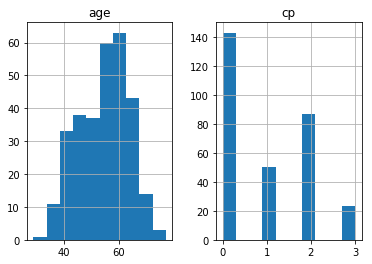

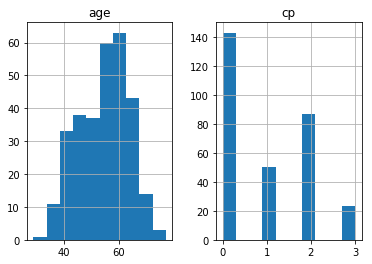

In [6]:
#df[['age']].hist()
df[['age', 'cp']].hist()
df[['age', 'cp']].hist()

In [7]:
#ct2_age = pd.crosstab(df.target, df.age)
#ct2_age.plot.bar(stacked=True)

#x = df['age'].value_counts()

#y_0 = df[df['target'] == 0]
#y_0 = y['age'].value_counts()

#y_1 = df[df['target'] == 1]
#y_1 = y['age'].value_counts()

#y_1 + y_0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025B9D716470>]],
      dtype=object)

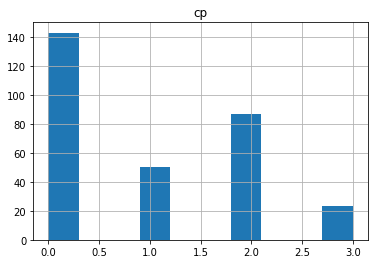

In [8]:
df[['cp']].hist()

#### Medical Background

- trestbps: resting blood pressure (in mm Hg on admission to the hospital) (Ruhepuls gemessen an Millimeter Quecksilbersäule, Durchschnittswert bei Erwachsenen: 120-129)
- chol: serum cholestoral in mg/dl (Cholesterin in mg pro Deziliter, Durchschnitt ist 240 mg/dl)
- fbs: (fasting blood sugar > 120 mg/dl) (1 = true (deutlich zu hoch); 0 = false) (Nüchternblutzucker, Durchschnitt: 65-100 ml/dl)
- restec: resting electrocardiographic results (EKG Ergebnisse --> 0 normal, 1 & 2 Abnormalitäten)
- thalach: maximum heart rate achieved (Maximale Herzfrequenz (bei größtmöglicher Anstrengung) Herzschläge/ Minute)
- exang: exercise induced angina (1 = yes; 0 = no) ("Engegefühl" bei sportlicher Aktivität)
- oldpeak: ST depression induced by exercise relative to rest (Befund bei EKG (ST Streckensenkung), der eine bestimmte Basislinie nicht unterschreiten sollte)
- slope: the slope of the peak exercise ST segment (EKG Ergebnisse, "peaks" des ST segments)
    -- Value 1: upsloping 
    -- Value 2: flat 
    -- Value 3: downsloping 
- ca: number of major vessels (0-3) colored by fluoroscopy (Betrachtung von Hauptgefäßen bei Durchführung einer Durchleuchtung. Verstopfte Gefäße werden beim Durchleuchten nicht erkannt -> Je mehr, desto besser)
- thal: thallium heart scan, 3 = normal; 6 = fixed defect; 7 = reversable defect (Test zur Qualität der Blutversorgung, Durchblutungsstörung Thalassämie, kann vererbt werden)
- target: 1 or 0

Text(0.5,1,'Distribution of Resting Blood Pressure')

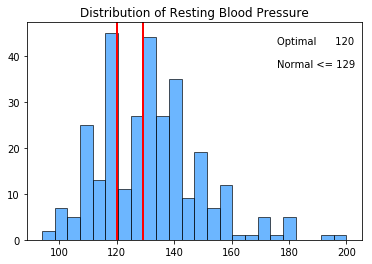

In [9]:
norm_bot = 120
norm_top = 129

result = plt.hist(df[['trestbps']].values, bins=24, color='dodgerblue', edgecolor='k', alpha=0.65)
plt.axvline(norm_bot, color='r', linewidth=2)
plt.axvline(norm_top, color='r', linewidth=2)

_, max_ = plt.ylim()

plt.text(160 + 160/10, 
         max_ - max_/10, 
         'Optimal      {:}'.format(norm_bot))

plt.text(160 + 160/10, 
         max_ - max_/10 - 5, 
         'Normal <= {:}'.format(norm_top))

plt.title('Distribution of Resting Blood Pressure')

Text(0.5,1,'Distribution of Cholesterine Concentration mg/dl')

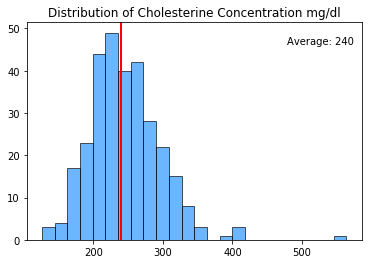

In [10]:
avg = 240

result = plt.hist(df[['chol']].values, bins=24, color='dodgerblue', edgecolor='k', alpha=0.65)
plt.axvline(avg, color='r', linewidth=2)

_, max_ = plt.ylim()

plt.text(435 + 435/10, 
         max_ - max_/10, 
         'Average: {:}'.format(avg))

plt.title('Distribution of Cholesterine Concentration mg/dl')

In [11]:
#pandas_profiling.ProfileReport(df)

### 2. Feature Selection

Um erkennen zu können, welche Attribute tatsächlich ausschalggebend für die Diagnose einer Herzkrankheit sind, können sowohl ihre Korrelationen mit dem Label "krank" oder "nicht krank", als auch ihre Verbidnung untereinander betrachtet werden. Die Matrix zeigt die jeweiligen Korrelationen auf Basis des Pearson Koeffizients, wobei eine Nähe zu dem Wert 1 eine starke Korrelation bedeutet. 

In [12]:
df.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


In [13]:
#plt.matshow(df.corr())

Die obige Matrix lässt eine erste Beurteilung der Signifikanz der Attribute zu. Um eine möglichst optimale Anzahl an repräsentativen Attributen bzw. Features zu erhalten, wird eine statistische Selektionsmethode gewählt:

In [14]:
from sklearn.feature_selection import f_classif, SelectKBest

In [15]:
def select_kbest_clf(data_frame, target, k=5):
    """
    Selecting K-Best features for classification
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    feat_selector = SelectKBest(f_classif, k=k)
    _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
    
    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores 

In [16]:
select_kbest_clf(df, 'target')

,F Score,P Value,Support,Attribute
0,16.116700,7.524801e-05,False,age
1,25.792191,6.678692e-07,False,sex
2,69.772271,2.469712e-15,True,cp
3,6.458169,1.154606e-02,False,trestbps
4,2.202983,1.387903e-01,False,chol
5,0.236942,6.267775e-01,False,fbs
6,5.777209,1.683990e-02,False,restecg
7,65.120104,1.697338e-14,True,thalach
8,70.952438,1.520814e-15,True,exang
9,68.551439,4.085346e-15,True,oldpeak


Die mit "True" gekennzeichneten Attribute sind laut der Analyse als Features am besten geeignet.

In [17]:
scores = select_kbest_clf(df, 'target')

In [18]:
features = scores['Attribute'].where(scores['Support']).dropna()
features

2          cp
7     thalach
8       exang
9     oldpeak
11         ca
Name: Attribute, dtype: object

In [19]:
type(features)

pandas.core.series.Series

In [20]:
df_selected = df[['cp', 'thalach', 'exang', 'oldpeak', 'ca', 'target']]

In [21]:
df_selected.head()

,cp,thalach,exang,oldpeak,ca,target
0,3,150,0,2.3,0,1
1,2,187,0,3.5,0,1
2,1,172,0,1.4,0,1
3,1,178,0,0.8,0,1
4,0,163,1,0.6,0,1


## Modeling

In [22]:
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import f_classif, SelectKBest

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

### Data Preprocessing

In [23]:
from sklearn.model_selection import train_test_split

X, y = df.iloc[:,:-1],df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

print('Training Shapes:', X_train.shape, y_train.shape)
print('Test Shapes:', X_test.shape, y_test.shape)

Training Shapes: (242, 13) (242,)
Test Shapes: (61, 13) (61,)


### Modeling - Linear Classifier

In [24]:
from sklearn.linear_model import SGDClassifier

sgdc_pipe  = Pipeline([
    ('kbest', SelectKBest(f_classif)),
    ('scaler', StandardScaler()),
    ('sgdc', SGDClassifier())
])

sgdc_pipe.set_params(
    kbest__k=5,
    sgdc__eta0=0.1, sgdc__random_state=random_state, sgdc__n_jobs=-1
)

sgdc_pipe.fit(X_train,y_train)

sgdc_pipe.score(X_test, y_test)

C:\Users\Marius\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.7377049180327869

In [25]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

sgdc_params = {
        'sgdc__penalty': ['l1', 'l2', 'none', 'elasticnet'],
        'sgdc__learning_rate': ['constant', 'optimal', 'invscaling'],
    
        'kbest__k': [3, 5, 7, 9, 11, 13]
        }

params_comb_all = int(4 * 3 * 6)
param_comb = int(params_comb_all / 2)

print('GridSearchCV parameter combinations: ' + str(params_comb_all) + '\n' + 'RandomizedSearchCV parameter combinations: ' + str(param_comb))

GridSearchCV parameter combinations: 72
RandomizedSearchCV parameter combinations: 36


In [26]:
grid_search_sgdc = GridSearchCV(sgdc_pipe, param_grid=sgdc_params, scoring='roc_auc', n_jobs=-1)
grid_search_sgdc.fit(X_train, y_train)

grid_search_sgdc.best_params_

C:\Users\Marius\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


{'kbest__k': 11, 'sgdc__learning_rate': 'invscaling', 'sgdc__penalty': 'l1'}

In [27]:
grid_search_sgdc.best_score_

0.8795689754367441

In [28]:
grid_search_sgdc.best_estimator_.score(X_test,y_test)

0.8852459016393442

### Modeling - DecisonTreeClassifier

In [29]:
from sklearn.tree import DecisionTreeClassifier

dtc_pipe = Pipeline([
    ('kbest', SelectKBest(f_classif)),
    ('scaler', StandardScaler()),
    ('dtc', DecisionTreeClassifier(random_state=random_state))
])

dtc_pipe.set_params(
    kbest__k=5
)

dtc_pipe.fit(X_train, y_train)

dtc_pipe.score(X_test, y_test)

0.819672131147541

In [30]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

dtc_params = {
        'dtc__max_depth': [2, 3, 5, 10, None],
        'dtc__max_leaf_nodes': [3, 5, 8, 10, 15, 20, None],
    
        'kbest__k': [3, 5, 7, 9, 11, 13]
        }

In [31]:
grid_search_dtc = GridSearchCV(dtc_pipe, param_grid=dtc_params, scoring='roc_auc', n_jobs=-1)
grid_search_dtc.fit(X_train, y_train)

grid_search_dtc.best_params_

{'dtc__max_depth': 3, 'dtc__max_leaf_nodes': None, 'kbest__k': 9}

In [32]:
grid_search_dtc.best_score_

0.7900416945871492

In [33]:
grid_search_dtc.best_estimator_.score(X_test, y_test)

0.819672131147541

### Modeling - KNN

In [34]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipe = Pipeline([
    ('kbest', SelectKBest(f_classif)),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

knn_pipe.set_params(
    kbest__k=5,
    knn__n_jobs=-1
)

knn_pipe.fit(X_train,y_train)

knn_pipe.score(X_test, y_test)

0.8360655737704918

In [35]:
knn_params = {
        'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'knn__leaf_size': [20, 30, 40],
    
        'kbest__k': [3, 5, 7, 9, 11, 13]
        }

In [36]:
grid_search_knn = GridSearchCV(knn_pipe, param_grid=knn_params, scoring='roc_auc', n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

grid_search_knn.best_params_

{'kbest__k': 11,
 'knn__algorithm': 'ball_tree',
 'knn__leaf_size': 20,
 'knn__n_neighbors': 13}

In [37]:
grid_search_knn.best_score_

0.8933395830090046

In [38]:
grid_search_knn.best_estimator_.score(X_test,y_test)

0.9016393442622951

In [39]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

y_pred = grid_search_knn.best_estimator_.predict(X_test)

print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_pred))

Precision:  0.90625
Recall:  0.90625
Confusion Matrix:  
 [[26  3]
 [ 3 29]]


### Modeling - xgboost

In [40]:
from xgboost import XGBClassifier

xgc_pipe = Pipeline([
    ('kbest', SelectKBest(f_classif)),
    ('scaler', StandardScaler()),
    ('xgc', XGBClassifier())
])

xgc_pipe.set_params(
    kbest__k=5
)

xgc_pipe.fit(X_train, y_train)

xgc_pipe.score(X_test, y_test)

C:\Users\Marius\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.819672131147541

In [41]:
xgc_params = {
        'xgc__learning_rate': [.0001, .001, .01, .1],
        'xgc__max_depth': [5, 10, 15, 20, 25],
        'xgc__n_estimators': [250, 500, 750, 1000],
    
        'kbest__k': [3, 5, 7, 9, 11, 13]
        }

params_comb_all = int(4 * 5 * 4 * 6)
param_comb = int(params_comb_all / 5)

print('GridSearchCV parameter combinations: ' + str(params_comb_all) + '\n' + 'RandomizedSearchCV parameter combinations: ' + str(param_comb))

GridSearchCV parameter combinations: 480
RandomizedSearchCV parameter combinations: 96


In [42]:
rnd_search_xgc = RandomizedSearchCV(xgc_pipe, param_distributions=xgc_params, n_iter=param_comb, scoring='roc_auc', n_jobs=-1, random_state=random_state )
rnd_search_xgc.fit(X_train, y_train)

rnd_search_xgc.best_params_

{'xgc__n_estimators': 750,
 'xgc__max_depth': 25,
 'xgc__learning_rate': 0.01,
 'kbest__k': 9}

In [43]:
rnd_search_xgc.best_score_

0.8916175378985296

In [44]:
rnd_search_xgc.best_estimator_.score(X_test,y_test)

C:\Users\Marius\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7868852459016393

In [45]:
y_pred = rnd_search_xgc.best_estimator_.predict(X_test)
confusion_matrix(y_test, y_pred)

C:\Users\Marius\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[23,  6],
       [ 7, 25]], dtype=int64)

In [46]:
grid_search_xgc = GridSearchCV(xgc_pipe, param_grid=xgc_params, scoring='roc_auc', n_jobs=-1)
grid_search_xgc.fit(X_train, y_train)

grid_search_xgc.best_params_

{'kbest__k': 9,
 'xgc__learning_rate': 0.01,
 'xgc__max_depth': 10,
 'xgc__n_estimators': 750}

In [47]:
grid_search_xgc.best_score_

0.8916175378985296

In [49]:
grid_search_xgc.best_estimator_.score(X_test,y_test)

C:\Users\Marius\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7868852459016393